In [1]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

import tests

In [2]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = np.rint(resize(lenna_rgb_512x512, (256, 256)) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

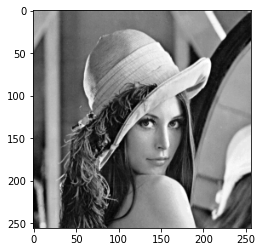

In [3]:
plt.imshow(lenna_gray_256x256, cmap='gray')

In [3]:
# GRADED CELL: BlockTransform

BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr', 'is_div'])

In [4]:
# GRADED CELL: FractalCompressionParams

FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)

In [5]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [6]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

In [7]:
# GRADED CELL: find_block_transform

def find_block_transform(image, resized_image, x, y, block_size, stride):
    def bright(r_bl, d_bl):
        return (np.sum(np.sum(r_bl)) - 0.75 * np.sum(np.sum(d_bl))) / block_size ** 2

    def MSE(r_bl, d_bl, q):
        dev = 0
        hei = r_bl.shape[0]
        wid = r_bl.shape[1]
        for i in range(hei):
            for j in range(wid):
                dev += (0.75 * d_bl[i][j] + q - r_bl[i][j]) ** 2
                if dev > best_deviation:
                    return dev
        return dev

    ran_block = np.array(image[x: x + block_size, y: y + block_size])
    best_transform_lst = [0 for _ in range(4)]
    dom_block = np.array(resized_image[0: block_size, 0: block_size])
    q_cur = bright(ran_block, dom_block)
    best_deviation = 0
    for i in range(block_size):
        for j in range(block_size):
            best_deviation += (0.75 * dom_block[i][j] + q_cur - ran_block[i][j]) ** 2

    height = resized_image.shape[0]
    width = resized_image.shape[1]
    for i in range(0, height - block_size + 1, stride):
        for j in range(0, width - block_size + 1, stride):
            for k in range(8):
                dom_block = np.rot90(resized_image[i: i + block_size, j: j + block_size], k % 4)
                if k // 4 == 1:
                    dom_block = dom_block.T
                q_cur = bright(ran_block, dom_block)
                deviation = MSE(ran_block, dom_block, q_cur)
                if deviation <= best_deviation:
                    best_deviation = deviation
                    best_transform_lst[0] = i
                    best_transform_lst[1] = j
                    best_transform_lst[2] = int(np.rint(q_cur))
                    best_transform_lst[3] = k

    best_transform = BlockTransform(best_transform_lst[0], best_transform_lst[1], best_transform_lst[2],
                                    best_transform_lst[3], 0)
    return best_deviation, best_transform

In [8]:
# GRADED CELL: perform_transform

def perform_transform(image, resized_image, transforms, block_size, ind=[-1]):
    def recfunc(block_size, transforms, ind):
        ind[0] += 1
        if transforms[ind[0]][4] == 1:
            ran_block = np.zeros((block_size, block_size))
            ran_block[:block_size//2, :block_size//2] = recfunc(block_size//2, transforms, ind).copy()
            ran_block[block_size//2:, :block_size//2] = recfunc(block_size//2, transforms, ind).copy()
            ran_block[:block_size//2, block_size//2:] = recfunc(block_size//2, transforms, ind).copy()
            ran_block[block_size//2:, block_size//2:] = recfunc(block_size//2, transforms, ind).copy()
            return ran_block
        else:
            xdb = transforms[ind[0]][0]
            ydb = transforms[ind[0]][1]
            dom_block = resized_image[xdb: xdb + block_size, ydb: ydb + block_size]
            dom_block = np.rot90(dom_block, transforms[ind[0]][3] % 4)
            if transforms[ind[0]][3] // 4 == 1:
                dom_block = dom_block.T
            return np.array([[0.75 * dom + transforms[ind[0]][2] for dom in dom_block[row]] for row in
                                  range(dom_block.shape[1])])

    height = image.shape[0]
    width = image.shape[1]
    transformed_image = np.array(image) * 1.0
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            transformed_image[i: i + block_size, j: j + block_size] = recfunc(block_size, transforms, ind).copy()
    for k0 in range(height):
        for k1 in range(height):
            if transformed_image[k0, k1] < 0:
                transformed_image[k0, k1] = 0.0
            elif transformed_image[k0, k1] > 255:
                transformed_image[k0, k1] = 255.0
    return transformed_image

In [9]:
tests.test_transform(find_block_transform, perform_transform)

IndexError: tuple index out of range

In [10]:
# GRADED CELL: BitBuffer

class BitBuffer:
    def __init__(self, buffer=None):
        self._buffer = buffer or bytearray()
        self._num_bits_ver = 0

    def to_bytearray(self):
        self.push(1, 1)
        while self._num_bits_ver != 8:
            self.push(0, 1)
        self._buffer.pop()
        return self._buffer

    def push(self, x, n_bits):
        while n_bits > 0:
            shift = min(self._num_bits_ver, n_bits)
            last_ind = len(self._buffer) - 1
            if last_ind >= 0:
                self._buffer[last_ind] = (self._buffer[last_ind] << shift) + (x & (0xff >> (8 - shift)))
            x >>= shift
            n_bits -= shift
            self._num_bits_ver -= shift
            if self._num_bits_ver == 0:
                self._buffer.append(0)
                self._num_bits_ver = 8

    def pop(self, n_bits):
        x = 0
        while n_bits > 0:
            shift = min(8 - self._num_bits_ver, n_bits)
            x <<= shift
            last_ind = len(self._buffer) - 1
            if last_ind >= 0:
                x += self._buffer[last_ind] & (0xff >> (8 - shift))
            n_bits -= shift
            self._num_bits_ver += shift
            self._buffer[len(self._buffer) - 1] >>= shift
            if self._num_bits_ver == 8:
                self._buffer.pop()
                self._num_bits_ver = 0

        return x

    def bufsize(self):
        return len(self._buffer)

In [11]:
tests.test_bit_buffer(BitBuffer)

'OK'

In [53]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    def __init__(self):
        self._num_bits_ver = None
        self._num_bits_hor = None
        self._num_bits_pix = None
        self._num_bits_tfm = None

    def _add_header(self, buffer, params):
        buffer.push(params[0], 16)
        buffer.push(params[2], 16)
        buffer.push(params[3], 16)
        buffer.push(int(100 * params[4]), 16)
        buffer.push(int(100 * params[5]), 16)
        buffer.push(params[6], 16)

    def _read_header(self, buffer):
        params_lst = [
            buffer.pop(16),
            buffer.pop(16) / 100,
            buffer.pop(16) / 100,
            buffer.pop(16),
            buffer.pop(16),
            buffer.pop(16),
            0
        ]
        params_lst[-1] = params_lst[-2]

        params = FractalCompressionParams(
            params_lst[-1],
            params_lst[-2],
            params_lst[-3],
            params_lst[-4],
            params_lst[-5],
            params_lst[-6],
            params_lst[-7]
        )
        return params

    def _add_to_buffer(self, buffer, transform, stride):
        if(transform[4]):
            buffer.push(1,1)
        else:
            buffer.push(transform[0], 8)
            buffer.push(transform[1], 8)
            buffer.push(1 if transform[2] < 0 else 0, 1)
            buffer.push(abs(transform[2]), 8)
            buffer.push(transform[3], 3)
            buffer.push(0, 1)

    def _read_transform(self, buffer, stride):
        if(buffer.pop(1)):
            return BlockTransform(0, 0, 0, 0, 1)
        else:
            tr = buffer.pop(3)
            di = buffer.pop(8)
            di *= 1 - 2 * buffer.pop(1)
            y = buffer.pop(8)
            x = buffer.pop(8)
            transform = BlockTransform(x, y, di, tr, 0)
            return transform

    def _ifs2buf(self, params, transformations, stride):
        buffer = BitBuffer()
        for t in transformations[::-1]:
            self._add_to_buffer(buffer, t, stride)
        self._add_header(buffer, params)

        return buffer

    def _buf2ifs(self, buffer):
        while buffer.pop(1) != 1:
            pass
        params = self._read_header(buffer)
        transforms=[]
        while buffer.bufsize()>0:
            transforms.append(self._read_transform(buffer, params[6]))

        return params, transforms

    def compress(self, image, block_size=16, stride=64, spatial_scale=0.5, intensity_scale=0.75):
        def recfunc(image, resized_image, x, y, block_size, stride):
            deviation, transform = find_block_transform(image, resized_image, x, y, block_size, stride)
            #print(deviation)
            if deviation >= 100 and block_size > 4:
                transformations.append(BlockTransform(0,0,0,0,1))
                cur_block_size = block_size // 2
                recfunc(image, resized_image, x, y, cur_block_size, stride)
                recfunc(image, resized_image, x + cur_block_size, y, cur_block_size, stride)
                recfunc(image, resized_image, x, y + cur_block_size, cur_block_size, stride)
                recfunc(image, resized_image, x + cur_block_size, y + cur_block_size, cur_block_size, stride)
            else:
                #print(deviation)
                transformations.append(transform)

        def mainfunc1(image, block_size, stride, spatial_scale, intensity_scale):
            #plt.imshow(image, cmap='gray')
            #plt.show()
            size = len(image)
            scale_size = int(size * spatial_scale)
            resized_image = resize(image / 255, (scale_size, scale_size)) * 255
            xs = range(0, size - block_size + 1, block_size)
            ys = range(0, size - block_size + 1, block_size)
            for x, y in tqdm(itertools.product(xs, ys), total=len(xs) * len(ys)):
                recfunc(image, resized_image, x, y, block_size, stride)
            #print(len(transformations))

        transformations = []
        colored = is_colored(image)
        params = FractalCompressionParams(len(image), len(image), colored, block_size, spatial_scale, intensity_scale, stride)

        if colored:
            cimage = np.array(rgb2yuv(image / 255))
            for i in range(3):
                image_tmp = np.array([[k1[i] for k1 in k2] for k2 in cimage])
                if i==1:
                    image_tmp = (image_tmp + 0.437) / 0.873
                elif i==2:
                    image_tmp = (image_tmp + 0.616) / 1.233
                mainfunc1(255 * image_tmp, block_size, stride, spatial_scale, intensity_scale)
        else:
            mainfunc1(image, block_size, stride, spatial_scale, intensity_scale)

        buffer = self._ifs2buf(params, transformations, stride)
        return buffer.to_bytearray()

    def compress2(self, image, quality=40):
        #return self.compress(image, block_size=16, stride=64)
        if quality==0:
            return self.compress(image, block_size=16, stride=64)
        elif quality==20:
            return self.compress(image, block_size=16, stride=32)
        elif quality==40:
            return self.compress(image, block_size=16, stride=16)
        elif quality==60:
            return self.compress(image, block_size=16, stride=12)
        elif quality==80:
            return self.compress(image, block_size=16, stride=8)
        elif quality==100:
            return self.compress(image, block_size=16, stride=6)

    def decompress(self, byte_array, num_iters=16):
        def mainfunc2(num_iters, params, scale_size, transforms, ind):
            image = np.array([[0 for _ in range(params[0])] for _ in range(params[0])])
            cur_ind = [ind[0]]
            for i in range(num_iters):
                ind[0] = cur_ind[0]
                resized_image = (resize(image / 255, (scale_size, scale_size)) * 255).copy()
                #ind = [-1]
                image = perform_transform(image, resized_image, transforms, params[3], ind).copy()
            #plt.imshow(image, cmap='gray')
            #plt.show()
            return image

        params, transforms = self._buf2ifs(BitBuffer(byte_array.copy()))
        size = params[0]
        scale_size = int(size * params[4])
        ind = [-1]
        if params[2]:
            cimage = np.array([[[0.0, 0.0, 0.0] for _ in range(params[0])] for _ in range(params[0])])
            for i in range(3):
                image_tmp = mainfunc2(num_iters, params, scale_size, transforms, ind).copy()
                for j1 in range(params[0]):
                    for j2 in range(params[0]):
                        cimage[j1, j2, i] = image_tmp[j1, j2] / 255
                        if i==1:
                            cimage[j1, j2, i] = (cimage[j1, j2, i] * 0.873 - 0.437)
                        elif i==2:
                            cimage[j1, j2, i] = (cimage[j1, j2, i] * 1.233 - 0.616)
                        '''if i==0 and(cimage[j1, j2, i] < 0 or cimage[j1, j2, i]  > 1):
                            print(j1, j2, i, ":",cimage[j1, j2, i])
                        if i==1 and(cimage[j1, j2, i] < -0.436 or cimage[j1, j2, i]  > 0.436):
                            print(j1, j2, i, ":",cimage[j1, j2, i])
                        if i==2 and(cimage[j1, j2, i] < -0.615 or cimage[j1, j2, i]  > 0.615):
                            print(j1, j2, i, ":",cimage[j1, j2, i])'''
            uouo = yuv2rgb((cimage)) * 255
            for k0 in range(params[0]):
                for k1 in range(params[0]):
                    for k2 in range(3):
                        if uouo[k0,k1,k2] < 0:
                            uouo[k0, k1, k2] = 0.0
                        elif uouo[k0,k1,k2] > 255:
                            uouo[k0, k1, k2] = 255.0
            image = uouo
        else:
            image = mainfunc2(num_iters, params, scale_size, transforms, ind).copy()

        return np.rint(image).astype('uint8')

## Пробуем применить FractalCompressor

In [54]:
comp = FractalCompressor()

In [26]:
result_16x4 = comp.compress(lenna_gray_256x256, block_size=16, stride=32)

 23%|█████████▋                                | 59/256 [00:08<00:28,  6.89it/s]


KeyboardInterrupt: 

Размер сжатого изображения в байтах == длина полученного массива `bytearray`

In [16]:
len(result_16x4)

15010

### Эволюция изображения при декомпрессии
Выглядит как увеличение фотографии в CSI: Место прреступления

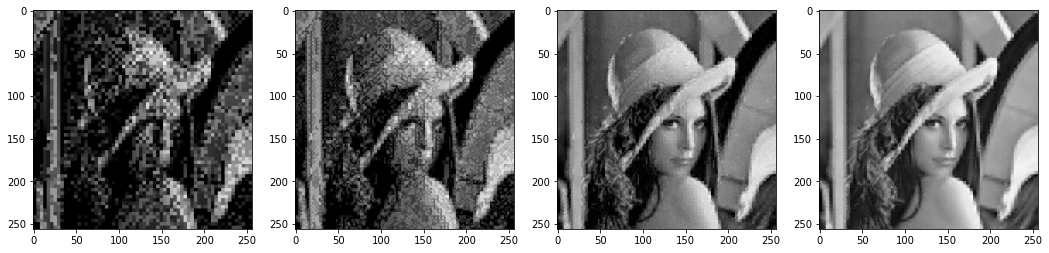

In [19]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

### Поиграемся с параметрами сжатия
Понятно, что при увеличении перебора мы, во-первых, увеличиваем время вычислений, а во-вторых, улучшаем итоговое качество изображения после сжатия и декомпрессии.

Чтобы увеличить перебор можно уменьшить размер шага `stride` или уменьшить размер доменного блока `block_size`. Но не рекомендуется делать блок размером меньше 4х4.

In [35]:
result_16x2 = comp.compress(lenna_gray_256x256, block_size=4, stride=32)

100%|██████████████████████████████████████| 4096/4096 [00:26<00:00, 155.30it/s]


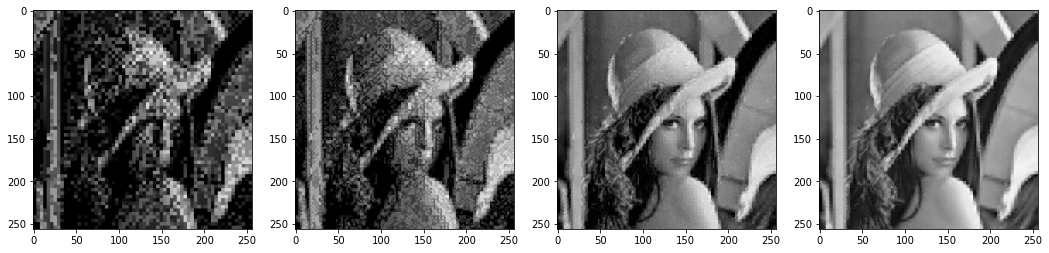

In [34]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [33]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

In [50]:
quality = [100, 80, 60, 40, 20, 0]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images]) / img.size
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs

In [44]:
#res = comp.compress2(lenna_gray_256x256, quality=100)
#res = comp.compress(lenna_gray_256x256, block_size=4, stride=32)
#len(res)

In [51]:
def test_and_plot_collection(collection):
    _, ax = plt.subplots(figsize=(8, 6))

    for image in collection:
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

In [ ]:
test_and_plot_collection([lenna_gray_256x256])

  4%|█▋                                        | 10/256 [00:30<12:49,  3.13s/it]

 16%|██████▉                                   | 42/256 [02:47<14:13,  3.99s/it]


KeyboardInterrupt: 

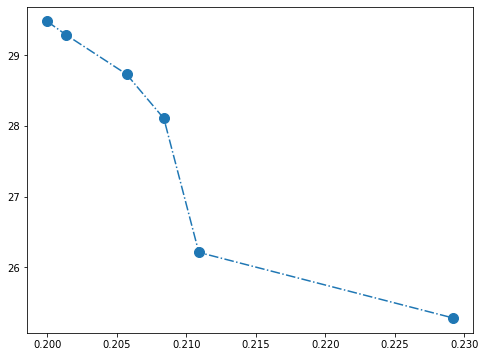

In [57]:
collection = []
for image_name in os.listdir('test_files'):
    image = resize(io.imread(os.path.join('test_files', image_name)), (256, 256))
    if is_colored(image):
        image = np.rint(rgb2gray(image) * 255).astype('uint8')
    collection.append(image)
test_and_plot_collection(collection)